# AI ETHICS Final Project

## Loan Default Prediction - Interpretability and Explainability


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installations and Imports

In [ ]:
pip install category_encoders shap lime interpret pdpbox PyALE aif360 folktables alibi joblib dice-ml fairlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of fairlearn to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of salib to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce
import shap
import lime
import lime.lime_tabular
import joblib
import dice_ml as dice


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.blackbox import PartialDependence
from interpret.perf import ROC
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from alibi.explainers import AnchorTabular
import dice_ml
from dice_ml.utils import helpers
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from imblearn.over_sampling import SMOTE

pip install 'aif360[inFairness]'


## EDA, Pre-Processing and Modeling

Read, Shape and Columns

In [ ]:
df_ = pd.read_csv("/content/drive/MyDrive/SEM 4/Training Data.csv")
df = df_.copy()
print("Shape of the dataset:" ,df.shape)
print("Columns in the Dataset:",df.columns)

Shape of the dataset: (252000, 13)
Columns in the Dataset: Index(['Id', 'Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')


Missing Values

In [ ]:
df.isnull().sum().sum()

0

View a sample

In [ ]:
df.sample(10)

Id   Income  Age  Experience Married/Single House_Ownership  \
188825  188826  2336648   25           9        married          rented   
169290  169291  1067890   41          14         single          rented   
67950    67951   385066   53           1         single          rented   
143019  143020  9238134   78           2         single          rented   
150777  150778  4841110   47          19         single          rented   
76940    76941  6868153   27           5        married           owned   
114118  114119  7529689   76           9         single          rented   
107435  107436  9063924   47          19         single          rented   
109146  109147  3090546   54           9         single          rented   
200584  200585  8030284   65           6         single          rented   

       Car_Ownership              Profession                 CITY  \
188825           yes          Microbiologist                 Pune   
169290           yes  Air_traffic_controller            Sambalpur   
67950             no                 Drafter                Bidar   
143019            no                    Chef            Erode[17]   
150777            no         Design_Engineer          Thoothukudi   
76940            yes   Technology_specialist          Tirunelveli   
114118            no            Army_officer  Rajahmundry[19][20]   
107435            no                Engineer            Ambarnath   
109146            no       Chemical_engineer                Alwar   
200584            no          Civil_engineer            Ghaziabad   

                 STATE  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
188825     Maharashtra                6                 11          0  
169290          Odisha                3                 12          0  
67950        Karnataka                1                 11          0  
143019      Tamil_Nadu                2                 11          0  
150777      Tamil_Nadu                7                 14          0  
76940       Tamil_Nadu                5                 12          0  
114118  Andhra_Pradesh                4                 10          0  
107435     Maharashtra                9                 11          0  
109146       Rajasthan                5                 12          1  
200584   Uttar_Pradesh                6                 12          0

Functions for encoding

In [ ]:
def clean_and_encode_location(df):
    df['CITY_'] = df['CITY'].replace(r'[\d+\[\]]','',regex=True)
    df['STATE_'] = df['STATE'].str.replace('_',' ')
    df['Location'] = df['CITY_']+df['STATE_']
    df['Location'] = df['Location'].replace('\s+','',regex=True)
    df['Location'] = df['Location'].replace('[,_-]+','',regex=True)
    df['Location'] = df['Location'].replace(r'[\d+\[\]]','',regex=True)
    df['Location'] = df['Location'].replace(r'[^a-zA-Z]','',regex=True)
    df['Location'] = df['Location'].str.lower()
    return df

def enocoding_binary_columns(df):
    df['enc_Married_Single'] = df['Married/Single'].map({'single' : 1, 'married':0})
    df['enc_car_ownership'] = df['Car_Ownership'].map({'no':0, 'yes':1})
    return df

def BNRY_ENCDR(df,col):
    encoder = ce.BinaryEncoder(cols=[col],return_df=True)
    df = encoder.fit_transform(df)
    return df

def OHE_ENCDR(df,col):
    encoder=ce.OneHotEncoder(cols=col,handle_unknown='return_nan',return_df=True,use_cat_names=True)
    df = encoder.fit_transform(df)
    return df

def LBL_ENCDR(df,col):
    le = LabelEncoder()
    enc_col = 'enc_' + col
    df[enc_col] = le.fit_transform(df[col])
    return df


In [ ]:
df_enc = clean_and_encode_location(df)
df_enc = OHE_ENCDR(df_enc,'Married/Single')
df_enc = OHE_ENCDR(df_enc,'Car_Ownership')

df_enc = BNRY_ENCDR(df_enc,'House_Ownership')

df_enc = LBL_ENCDR(df_enc,'Profession')
df_enc = LBL_ENCDR(df_enc,'Location')

df_enc.drop(['Id','CITY', 'STATE'],axis=1,inplace=True)

print("Shape after encoding and dropping:", df_enc.shape)

df_enc.head()

Shape after encoding and dropping: (252000, 18)


Income  Age  Experience  Married/Single_single  Married/Single_married  \
0  1303834   23           3                    1.0                     0.0   
1  7574516   40          10                    1.0                     0.0   
2  3991815   66           4                    0.0                     1.0   
3  6256451   41           2                    1.0                     0.0   
4  5768871   47          11                    1.0                     0.0   

   House_Ownership_0  House_Ownership_1  Car_Ownership_no  Car_Ownership_yes  \
0                  0                  1               1.0                0.0   
1                  0                  1               1.0                0.0   
2                  0                  1               1.0                0.0   
3                  0                  1               0.0                1.0   
4                  0                  1               1.0                0.0   

            Profession  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  \
0  Mechanical_engineer                3                 13          0   
1   Software_Developer                9                 13          0   
2     Technical_writer                4                 10          0   
3   Software_Developer                2                 12          1   
4        Civil_servant                3                 14          1   

             CITY_          STATE_                  Location  enc_Profession  \
0             Rewa  Madhya Pradesh         rewamadhyapradesh              33   
1         Parbhani     Maharashtra       parbhanimaharashtra              43   
2        Alappuzha          Kerala           alappuzhakerala              47   
3      Bhubaneswar          Odisha         bhubaneswarodisha              43   
4  Tiruchirappalli      Tamil Nadu  tiruchirappallitamilnadu              11   

   enc_Location  
0           251  
1           227  
2             8  
3            54  
4           296

In [ ]:
df_enc.describe().apply(lambda s: s.apply('{0:.4f}'.format))

Income          Age   Experience Married/Single_single  \
count   252000.0000  252000.0000  252000.0000           252000.0000   
mean   4997116.6653      49.9541      10.0844                0.8979   
std    2878311.0136      17.0639       6.0026                0.3028   
min      10310.0000      21.0000       0.0000                0.0000   
25%    2503015.0000      35.0000       5.0000                1.0000   
50%    5000694.5000      50.0000      10.0000                1.0000   
75%    7477502.0000      65.0000      15.0000                1.0000   
max    9999938.0000      79.0000      20.0000                1.0000   

      Married/Single_married House_Ownership_0 House_Ownership_1  \
count            252000.0000       252000.0000       252000.0000   
mean                  0.1021            0.0798            0.9715   
std                   0.3028            0.2709            0.1664   
min                   0.0000            0.0000            0.0000   
25%                   0.0000            0.0000            1.0000   
50%                   0.0000            0.0000            1.0000   
75%                   0.0000            0.0000            1.0000   
max                   1.0000            1.0000            1.0000   

      Car_Ownership_no Car_Ownership_yes CURRENT_JOB_YRS CURRENT_HOUSE_YRS  \
count      252000.0000       252000.0000     252000.0000       252000.0000   
mean            0.6984            0.3016          6.3339           11.9978   
std             0.4589            0.4589          3.6471            1.3990   
min             0.0000            0.0000          0.0000           10.0000   
25%             0.0000            0.0000          3.0000           11.0000   
50%             1.0000            0.0000          6.0000           12.0000   
75%             1.0000            1.0000          9.0000           13.0000   
max             1.0000            1.0000         14.0000           14.0000   

         Risk_Flag enc_Profession enc_Location  
count  252000.0000    252000.0000  252000.0000  
mean        0.1230        25.2767     158.1363  
std         0.3284        14.7285      92.2037  
min         0.0000         0.0000       0.0000  
25%         0.0000        13.0000      78.0000  
50%         0.0000        26.0000     157.0000  
75%         0.0000        38.0000     238.0000  
max         1.0000        50.0000     316.0000

Log Transformation of Income column

In [ ]:
df_enc['Log_Income'] = np.log1p(df_enc['Income'])
df_enc.loc[:,['Log_Income', 'Age', 'Experience','CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS','enc_Profession', 'enc_Location']].describe().apply(lambda s: s.apply('{0:.4f}'.format))

Log_Income          Age   Experience CURRENT_JOB_YRS  \
count  252000.0000  252000.0000  252000.0000     252000.0000   
mean       15.1247      49.9541      10.0844          6.3339   
std         0.9743      17.0639       6.0026          3.6471   
min         9.2410      21.0000       0.0000          0.0000   
25%        14.7330      35.0000       5.0000          3.0000   
50%        15.4251      50.0000      10.0000          6.0000   
75%        15.8274      65.0000      15.0000          9.0000   
max        16.1181      79.0000      20.0000         14.0000   

      CURRENT_HOUSE_YRS enc_Profession enc_Location  
count       252000.0000    252000.0000  252000.0000  
mean            11.9978        25.2767     158.1363  
std              1.3990        14.7285      92.2037  
min             10.0000         0.0000       0.0000  
25%             11.0000        13.0000      78.0000  
50%             12.0000        26.0000     157.0000  
75%             13.0000        38.0000     238.0000  
max             14.0000        50.0000     316.0000

Drop Uneccessary Columns

In [ ]:
df_enc.columns

Index(['Income', 'Age', 'Experience', 'Married/Single_single',
       'Married/Single_married', 'House_Ownership_0', 'House_Ownership_1',
       'Car_Ownership_no', 'Car_Ownership_yes', 'Profession',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag', 'CITY_', 'STATE_',
       'Location', 'enc_Profession', 'enc_Location', 'Log_Income'],
      dtype='object')

In [ ]:
df_enc.drop(['Income','CITY_', 'STATE_', 'Location','Profession'],axis=1,inplace =True)
df_enc.columns

Index(['Age', 'Experience', 'Married/Single_single', 'Married/Single_married',
       'House_Ownership_0', 'House_Ownership_1', 'Car_Ownership_no',
       'Car_Ownership_yes', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag', 'enc_Profession', 'enc_Location', 'Log_Income'],
      dtype='object')

In [ ]:
df_enc._get_numeric_data().columns

Index(['Age', 'Experience', 'Married/Single_single', 'Married/Single_married',
       'House_Ownership_0', 'House_Ownership_1', 'Car_Ownership_no',
       'Car_Ownership_yes', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag', 'enc_Profession', 'enc_Location', 'Log_Income'],
      dtype='object')

#### Over sample and balance on the train set

In [ ]:
train_data = df_enc.sample(frac = 0.8,random_state = 40).copy()
train_data.shape

(201600, 14)

In [ ]:
test_data = df_enc.loc[df_enc.index.isin([i for i in set([i for i in df_enc.index]) - set([i for i in train_data.index])]),: ].copy()
print(test_data.shape)
print(test_data.columns)

(50400, 14)
Index(['Age', 'Experience', 'Married/Single_single', 'Married/Single_married',
       'House_Ownership_0', 'House_Ownership_1', 'Car_Ownership_no',
       'Car_Ownership_yes', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag', 'enc_Profession', 'enc_Location', 'Log_Income'],
      dtype='object')


### Oversampling and Balancing Train Data

In [ ]:
X = train_data.copy()
X.drop('Risk_Flag',axis=1,inplace=True)


y = train_data.loc[:,['Risk_Flag']].copy()

In [ ]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
print(f"Before Sampling: {y.value_counts()}")
X_os, y_os = smote.fit_resample(X, y)
print(f"After Sampling: {y_os.value_counts()}")

print(X_os.shape, y_os.shape)

Before Sampling: Risk_Flag
0            176755
1             24845
dtype: int64
After Sampling: Risk_Flag
0            176755
1             88377
dtype: int64
(265132, 13) (265132, 1)


### Model Selection

Training the Model on Oversampled Balanced Train Data

In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.2, random_state=1)

#### Random Forest

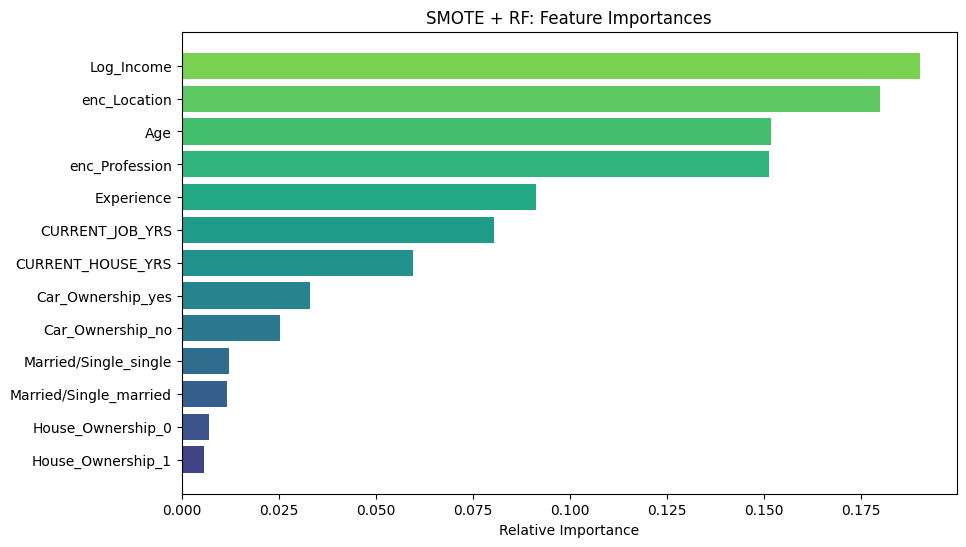

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#Feature Importance
importances = rf_model.feature_importances_
features = X_os.columns
indices = np.argsort(importances)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(indices)))
plt.figure(figsize=(10, 6))
plt.title('SMOTE + RF: Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=colors, align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Train Set Prediction

In [ ]:
# Predictions for train set
y_pred_rf_train = rf_model.predict(X_train)

# Metrics for train set
accuracy_train = accuracy_score(y_train, y_pred_rf_train)
precision_train = precision_score(y_train, y_pred_rf_train)
recall_train = recall_score(y_train, y_pred_rf_train)
f1_train = f1_score(y_train, y_pred_rf_train)
roc_auc_train = roc_auc_score(y_train, y_pred_rf_train)

print(f"Train Set Metrics:\nAccuracy: {accuracy_train:.2f}\nPrecision: {precision_train:.2f}\nRecall: {recall_train:.2f}\nF1-Score: {f1_train:.2f}\nROC_AUC: {roc_auc_train:.2f}\n")

# Confusion Matrix for train set
disp_train = ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_train,
    y_train,
    cmap=plt.cm.Blues_r,
)
disp_train.ax_.set_title("Random Forest Confusion Matrix - Train Set")
plt.show()


Train Set Metrics:
Accuracy: 0.94
Precision: 0.86
Recall: 1.00
F1-Score: 0.92
ROC_AUC: 0.96



Test Set Prediction after training on Important Features


Predicting using Test data with SMOTE + Random Forest Classifier with important features

Accuracy: 0.91
Precision: 0.84
Recall: 0.91
F1-Score: 0.87
ROC_AUC: 0.91



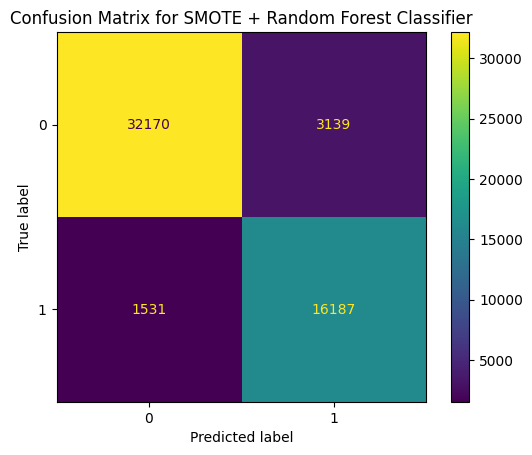

In [ ]:
X_os_if  = X_os.drop(['House_Ownership_0','House_Ownership_1','Married/Single_single', 'Married/Single_married'],axis=1).copy()

X_train_if, X_test_if, y_train_if, y_test_if = train_test_split(X_os_if, y_os, test_size=0.2)
smote_RF = RandomForestClassifier(random_state=42).fit(X_train_if, y_train_if)

y_pred_smote_RF_if = smote_RF.predict(X_test_if)
accuracy = accuracy_score(y_test_if, y_pred_smote_RF_if)
precision = precision_score(y_test_if, y_pred_smote_RF_if)
recall = recall_score(y_test_if, y_pred_smote_RF_if)
f1 = f1_score(y_test_if, y_pred_smote_RF_if)
roc_auc = roc_auc_score(y_test_if, y_pred_smote_RF_if)
print('\nPredicting using Test data with SMOTE + Random Forest Classifier with important features\n')
print(f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1-Score: {f1:.2f}\nROC_AUC: {roc_auc:.2f}\n")
cm = confusion_matrix(y_test_if, y_pred_smote_RF_if)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for SMOTE + Random Forest Classifier')
plt.show()

Feature Importance using Random Forest

In [ ]:
#Feature Importance
importances = smote_RF.feature_importances_
features = X_os_if.columns
indices = np.argsort(importances)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(indices)))
plt.figure(figsize=(8, 6))
plt.title('SMOTE + RF: Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=colors, align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Predict Unseen Test set and check accuracy

In [ ]:
final_features = X_train_if.columns.tolist()

X_train_if.columns

Index(['Age', 'Experience', 'Car_Ownership_no', 'Car_Ownership_yes',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'enc_Profession',
       'enc_Location', 'Log_Income'],
      dtype='object')


Predicting using Unseen Test data with SMOTE + Random Forest Classifier

Accuracy: 0.89
Precision: 0.54
Recall: 0.77
F1-Score: 0.64
ROC_AUC: 0.84



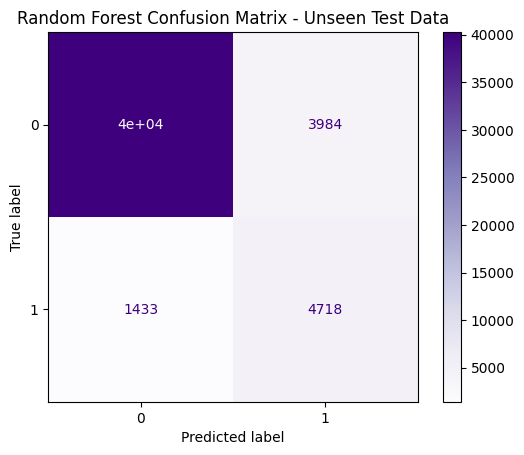

In [ ]:
# Prepare unseen test data - Unbalanced test data before OverSampling
X_unseen = test_data.drop(['Risk_Flag'], axis=1).copy()

y_unseen = test_data['Risk_Flag']  # Ground truth labels for unseen test

X_unseen = X_unseen[final_features]

# Predict
y_pred_unseen = smote_RF.predict(X_unseen)

# Metrics
accuracy = accuracy_score(y_unseen, y_pred_unseen)
precision = precision_score(y_unseen, y_pred_unseen)
recall = recall_score(y_unseen, y_pred_unseen)
f1 = f1_score(y_unseen, y_pred_unseen)
roc_auc = roc_auc_score(y_unseen, y_pred_unseen)

# Print Metrics
print('\nPredicting using Unseen Test data with SMOTE + Random Forest Classifier\n')
print(f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1-Score: {f1:.2f}\nROC_AUC: {roc_auc:.2f}\n")

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    smote_RF,
    X_unseen,
    y_unseen,
    cmap=plt.cm.Purples,
)
disp.ax_.set_title('Random Forest Confusion Matrix - Unseen Test Data')
plt.show()

## Interpretability and Explainability

### EBM

In [ ]:
ebm = ExplainableBoostingClassifier(
    interactions=0,
    n_jobs=-1,
    max_rounds=200,
    max_bins=128,
    validation_size=0,
    early_stopping_rounds=20,
    random_state=42
)

ebm.fit(X_train_if, y_train_if)

ExplainableBoostingClassifier(early_stopping_rounds=20, interactions=0,
                              max_bins=128, max_rounds=200, n_jobs=-1,
                              validation_size=0)

In [ ]:
show(ebm.explain_global())

### SHAP

In [ ]:
# Small sample from Unseen Test set
small_X_test_if = X_test_if.sample(200, random_state=42)

In [ ]:
# Initialize SHAP Explainer
explainer = shap.Explainer(smote_RF.predict, X_train_if)


shap_values = explainer(small_X_test_if)

ExactExplainer explainer: 201it [03:05,  1.05it/s]


In [ ]:
# Summary plot
shap.summary_plot(shap_values.values, small_X_test_if)

In [ ]:
shap.summary_plot(shap_values.values, small_X_test_if, plot_type="bar")

In [ ]:
#Pick a Sample for Detailed Explanations
sample_idx_pos = 127

sample_idx_neg = 22

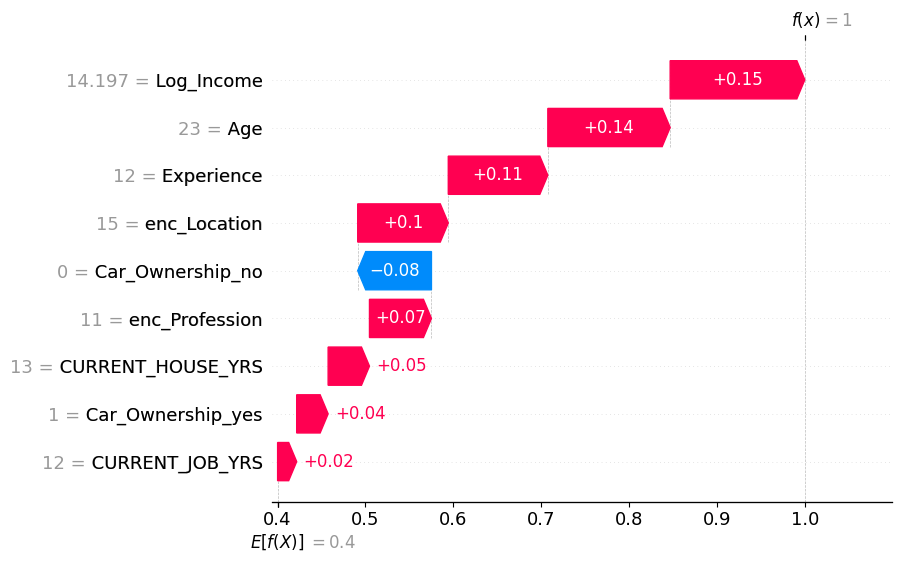

In [ ]:
#SHAP Waterfall Plot (for one sample)
shap.plots.waterfall(shap_values[sample_idx_pos])

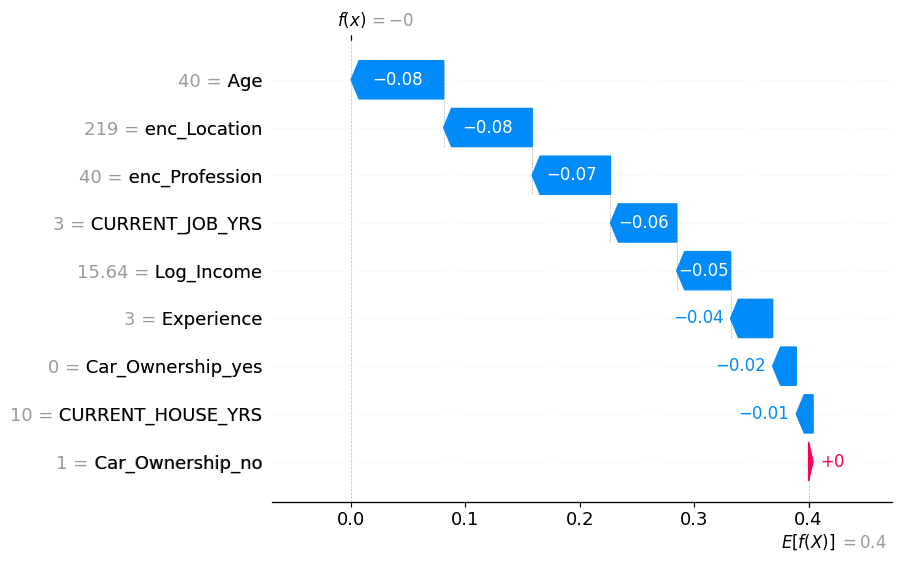

In [ ]:
#SHAP Waterfall Plot (for one sample)
shap.plots.waterfall(shap_values[sample_idx_neg])

In [ ]:
#SHAP Force Plot (for one sample)
shap.initjs()
shap.plots.force(shap_values[sample_idx_pos])

In [ ]:
#SHAP Force Plot (for one sample)
shap.initjs()
shap.plots.force(shap_values[sample_idx_neg])

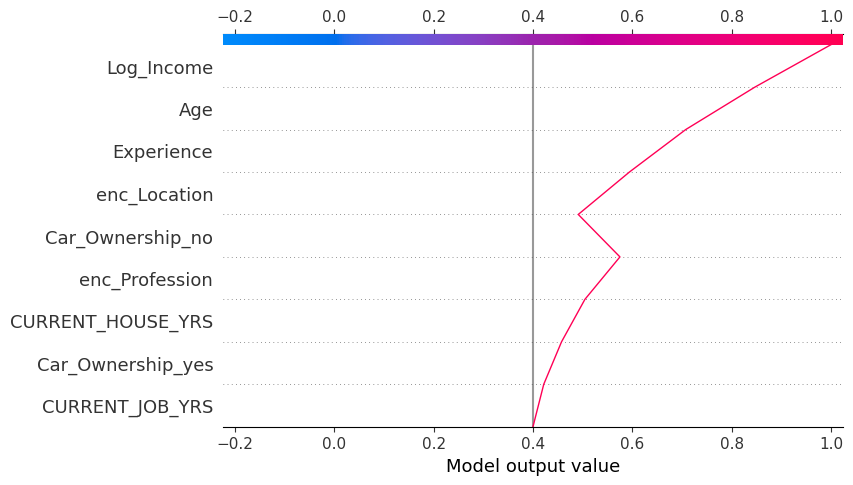

In [ ]:
# SHAP Decision Plot (for single sample)
shap.plots.decision(
    shap_values.base_values[0],
    shap_values.values[sample_idx_pos],
    feature_names=X_os_if.columns.tolist()
)

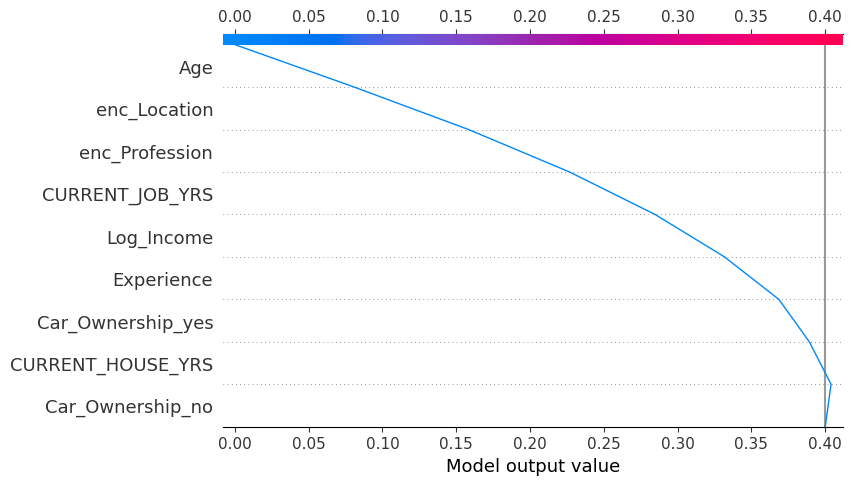

In [ ]:
# SHAP Decision Plot (for single sample)
shap.plots.decision(
    shap_values.base_values[0],
    shap_values.values[sample_idx_neg],
    feature_names=X_os_if.columns.tolist()
)

In [ ]:
#SHAP Decision Plot (for multiple samples)
sample_indices = np.random.choice(range(small_X_test_if.shape[0]), 10, replace=False)
shap.plots.decision(
    shap_values.base_values[0],
    shap_values.values[sample_indices],
    feature_names=X_os_if.columns.tolist()
)

### LIME

In [ ]:
# LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_if.values,
    feature_names=X_train_if.columns.tolist(),
    class_names=['No Risk', 'Risk'],
    mode='classification'
)

# Select a Test Instance
sample_idx = 146
instance = X_test_if.iloc[sample_idx]

# Generate LIME Explanation
lime_exp = lime_explainer.explain_instance(
    data_row=instance.values,
    predict_fn=smote_RF.predict_proba
)

# Show LIME Explanation
lime_exp.show_in_notebook(show_table=True, show_all=False)

### PDP

In [ ]:
# Define features and grid layout
features_to_plot = [
    'Age', 'Experience', 'Car_Ownership_no', 'Car_Ownership_yes',
    'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'enc_Profession',
    'enc_Location', 'Log_Income'
]

n_cols = 3
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))
axes = axes.flatten()

# Loop through each feature
for i, feature in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(
        smote_RF,
        X_test_if,
        [feature],
        ax=axes[i]
    )
    axes[i].set_title(f'PDP for {feature}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### ALE

INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.


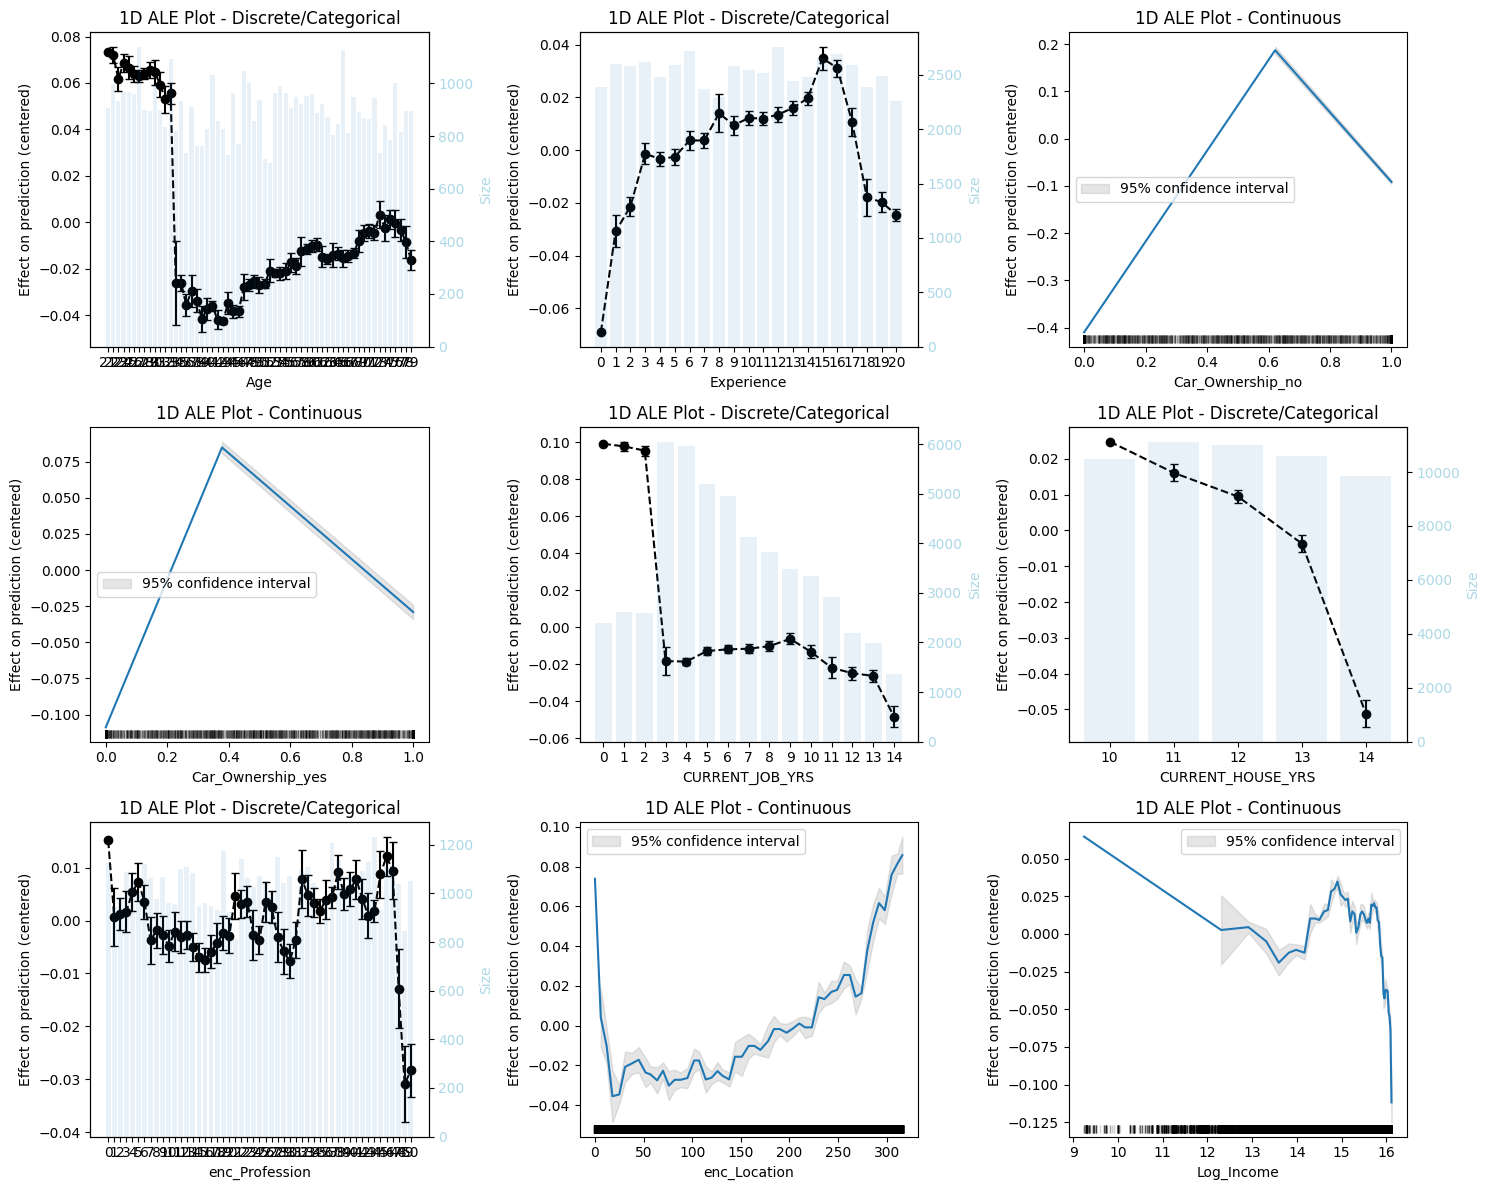

In [61]:
# Features to plot
features_to_plot = [
    'Age', 'Experience', 'Car_Ownership_no', 'Car_Ownership_yes',
    'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'enc_Profession',
    'enc_Location', 'Log_Income'
]

# Grid layout
n_cols = 3
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))
axes = axes.flatten()

# Loop through features and plot ALE
for i, feature in enumerate(features_to_plot):
    ale(
        model=smote_RF,
        X=X_test_if,
        feature=[feature],
        include_CI=True,
        grid_size=50,
        ax=axes[i],
        fig=fig
    )

# Turn off any empty plots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### Anchors

In [ ]:
#Define prediction function
predict_fn = lambda x: smote_RF.predict(x)

#Feature names
feature_names = X_os_if.columns.tolist()

#Initialize the Anchor explainer
anchor_explainer = AnchorTabular(predict_fn, feature_names)

#Fit the explainer on your balanced data
anchor_explainer.fit(X_os_if.values, disc_perc=(10, 25, 50, 75, 90))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (10, 25, 50, 75, 90)},
  'version': '0.9.6'}
)

In [ ]:
#Find an instance where prediction is 0
for idx in range(len(X_os_if)):
    instance = X_os_if.iloc[idx].values.reshape(1, -1)
    pred = smote_RF.predict(instance)[0]
    if pred == 0:
        instance_0_idx = idx
        break

# Explain
instance_0 = X_os_if.iloc[instance_0_idx].values.reshape(1, -1)
prediction_0 = smote_RF.predict(instance_0)[0]

print(f"\nAnchor Explanation for instance {instance_0_idx} (Prediction: {prediction_0}):")

anchor_explanation_0 = anchor_explainer.explain(instance_0, threshold=0.95)

print(f"Anchor: {anchor_explanation_0.anchor}")
print(f"Precision: {anchor_explanation_0.precision:.2f}")
print(f"Coverage: {anchor_explanation_0.coverage:.2f}")


Anchor Explanation for instance 0 (Prediction: 0):
Anchor: ['CURRENT_JOB_YRS > 9.00', 'CURRENT_HOUSE_YRS > 12.00', '5.00 < enc_Profession <= 26.00', '79.00 < enc_Location <= 157.00']
Precision: 0.96
Coverage: 0.01


In [ ]:
# Find an instance where prediction is 1
for idx in range(len(X_os_if)):
    instance = X_os_if.iloc[idx].values.reshape(1, -1)
    pred = smote_RF.predict(instance)[0]
    if pred == 1:
        instance_1_idx = idx
        break

# Explain
instance_1 = X_os_if.iloc[instance_1_idx].values.reshape(1, -1)
prediction_1 = smote_RF.predict(instance_1)[0]

print(f"\nAnchor Explanation for instance {instance_1_idx} (Prediction: {prediction_1}):")

anchor_explanation_1 = anchor_explainer.explain(instance_1, threshold=0.95)

print(f"Anchor: {anchor_explanation_1.anchor}")
print(f"Precision: {anchor_explanation_1.precision:.2f}")
print(f"Coverage: {anchor_explanation_1.coverage:.2f}")



Anchor Explanation for instance 4 (Prediction: 1):
Anchor: ['CURRENT_JOB_YRS <= 2.00', 'enc_Profession <= 5.00', 'Car_Ownership_no > 0.00', 'Log_Income <= 15.82', 'CURRENT_HOUSE_YRS <= 10.00', 'enc_Location <= 79.00', 'Age <= 26.00']
Precision: 0.97
Coverage: 0.00


### Counterfactuals

In [ ]:
# Combine features and target into one DataFrame
data_df = X_os_if.copy()
data_df['Risk_Flag'] = y_os

# Identify continuous and categorical features
continuous_features = data_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
continuous_features.remove('Risk_Flag')  # Remove target from features
categorical_features = data_df.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
# Create DiCE data object
d = dice_ml.Data(dataframe=data_df,
                 continuous_features=continuous_features,
                 categorical_features=categorical_features,
                 outcome_name='Risk_Flag')

# Create DiCE model object
m = dice_ml.Model(model=smote_RF, backend='sklearn')

# Initialize DiCE explainer
exp = dice_ml.Dice(d, m, method='random')


In [ ]:
def cf(desired_pred, total_CFs=3):
    for idx in range(len(X_os_if)):
        instance = X_os_if.iloc[idx]
        pred = smote_RF.predict(instance.values.reshape(1, -1))[0]
        if pred == desired_pred:
            query_instance = pd.DataFrame([instance], columns=X_os_if.columns)
            break
    else:
        print(f"No instance found with prediction = {desired_pred}")
        return

    try:
        dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=total_CFs, desired_class="opposite")
        return dice_exp.visualize_as_dataframe(show_only_changes=True)
    except Exception as e:
        print(f"Error generating counterfactuals: {e}")


In [ ]:
cf(desired_pred=0)

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

Query instance (original outcome : 0)


Age  Experience  Car_Ownership_no  Car_Ownership_yes  CURRENT_JOB_YRS  \
0  38.0        14.0               1.0                0.0             11.0   

   CURRENT_HOUSE_YRS  enc_Profession  enc_Location  Log_Income  Risk_Flag  
0               13.0            24.0         113.0   14.870461          0


Diverse Counterfactual set (new outcome: 1)


Age Experience Car_Ownership_no Car_Ownership_yes CURRENT_JOB_YRS  \
0   -          -                -               0.5               -   
1   -          -              0.9                 -               -   
2   -          -                -               0.4             8.0   

  CURRENT_HOUSE_YRS enc_Profession enc_Location Log_Income Risk_Flag  
0              14.0              -            -          -       1.0  
1                 -           20.0            -          -       1.0  
2                 -              -            -          -       1.0

In [ ]:
cf(desired_pred=1)

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

Query instance (original outcome : 1)


Age  Experience  Car_Ownership_no  Car_Ownership_yes  CURRENT_JOB_YRS  \
0  24.0         1.0               1.0                0.0              1.0   

   CURRENT_HOUSE_YRS  enc_Profession  enc_Location  Log_Income  Risk_Flag  
0               10.0             1.0          79.0   15.602582          1


Diverse Counterfactual set (new outcome: 0)


Age Experience Car_Ownership_no Car_Ownership_yes CURRENT_JOB_YRS  \
0   -          -                -                 -               -   
1   -       20.0                -                 -               -   
2   -          -                -                 -             4.0   

  CURRENT_HOUSE_YRS enc_Profession enc_Location Log_Income Risk_Flag  
0                 -              -            -  12.003021       0.0  
1                 -              -            -   9.928292       0.0  
2                 -              -            -  12.614422       0.0

### Fairness Metrics

AIF360

In [ ]:
features_to_test = ['Age', 'Log_Income', 'enc_Location', 'enc_Profession']

# Get model predictions
y_pred_test = smote_RF.predict(X_test_if).astype(int)

for feature in features_to_test:
    print(f"\nFairness Metrics Based on {feature} (Model Predictions)\n")

    temp_df = X_test_if.copy()
    temp_df['Risk_Flag'] = y_pred_test  # Use predictions instead of ground truth

    # Use median to split into protected groups
    threshold = temp_df[feature].median()
    temp_df['Protected_Attr'] = np.where(temp_df[feature] >= threshold, 1, 0)

    temp_df = temp_df.dropna().reset_index(drop=True)

    # Create AIF360 BinaryLabelDataset
    aif_data = BinaryLabelDataset(
        df=temp_df,
        label_names=['Risk_Flag'],
        protected_attribute_names=['Protected_Attr']
    )

    # Fairness metrics
    metric = BinaryLabelDatasetMetric(
        dataset=aif_data,
        privileged_groups=[{'Protected_Attr': 1}],
        unprivileged_groups=[{'Protected_Attr': 0}]
    )

    # Print results
    print(f"Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")
    print(f"Disparate Impact: {metric.disparate_impact():.4f}")
    print(f"Difference in Mean Outcomes: {metric.mean_difference():.4f}")


Fairness Metrics Based on Age (Model Predictions)

Statistical Parity Difference: 0.0194
Disparate Impact: 1.0547
Difference in Mean Outcomes: 0.0194

Fairness Metrics Based on Log_Income (Model Predictions)

Statistical Parity Difference: 0.0146
Disparate Impact: 1.0408
Difference in Mean Outcomes: 0.0146

Fairness Metrics Based on enc_Location (Model Predictions)

Statistical Parity Difference: -0.0035
Disparate Impact: 0.9905
Difference in Mean Outcomes: -0.0035

Fairness Metrics Based on enc_Profession (Model Predictions)

Statistical Parity Difference: -0.0051
Disparate Impact: 0.9861
Difference in Mean Outcomes: -0.0051


AIF360 Interpretation

Based on the results, we see that Statistical Parity Difference and Disparate Impact for the features considered are almost equal to 0 and 1 respectively, the features are biased in a very negligible amounts.

Statistical Parity = 0 (Perferct Fairness)
Disparate Impact = 1 (Perfect Fairness)

So, considering these 2 factors, we can conclude that these features are adding negligible bias to the model. Hence the model is quite fair with respect to the considered features.


Fairlearn

In [ ]:
features_to_test = ['Age', 'Log_Income', 'enc_Location', 'enc_Profession']

# Model predictions
y_pred = smote_RF.predict(X_test_if)

# Loop over each feature
for feature in features_to_test:
    print(f"\nFairness Metrics for: {feature}")

    # Create protected attribute using median split
    protected_attr = X_test_if[feature] >= X_test_if[feature].median()

    # Create metric frame
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1': f1_score,
        'Selection Rate': selection_rate
    }

    mf = MetricFrame(
        metrics=metrics,
        y_true=y_test_if,
        y_pred=y_pred,
        sensitive_features=protected_attr
    )

    # Display group-wise metrics
    print(mf.by_group)

    # Print global fairness metrics
    print(f"Demographic Parity Difference: {demographic_parity_difference(y_test_if, y_pred, sensitive_features=protected_attr):.4f}")
    print(f"Equalized Odds Difference: {equalized_odds_difference(y_test_if, y_pred, sensitive_features=protected_attr):.4f}")



Fairness Metrics for: Age
       Accuracy  Precision    Recall        F1  Selection Rate
Age                                                           
False  0.916141   0.849020  0.920722  0.883419        0.374231
True   0.907784   0.825683  0.906091  0.864020        0.354824
Demographic Parity Difference: 0.0194
Equalized Odds Difference: 0.0146

Fairness Metrics for: Log_Income
            Accuracy  Precision    Recall        F1  Selection Rate
Log_Income                                                         
False       0.910782   0.838035  0.914811  0.874742        0.371737
True        0.913081   0.837099  0.912323  0.873094        0.357178
Demographic Parity Difference: 0.0146
Equalized Odds Difference: 0.0047

Fairness Metrics for: enc_Location
              Accuracy  Precision    Recall        F1  Selection Rate
enc_Location                                                         
False         0.913652   0.841366  0.913746  0.876064        0.362720
True          0.910214   

Fairlearn Interpretation

Based on the results, we see that Demographic Parity Difference and Equalized Odds Difference for the features considered are almost equal to 0. Hence, the features are biased in a very negligible amounts.

Demographic Parity Difference = 0 (Perferct Fairness)
Equalized Odds Difference = 0 (Perfect Fairness)

So, considering these 2 factors, we can conclude that these features are adding negligible bias to the model. Hence the model is quite fair with respect to the considered features.
